# Processing the capillary force video
+ date: 2017-05-30

## Frames Export
Get frame rate information
```sh
videoname=T-L\ _\ 1-50\ tip-tip.avi
ffmpeg -i $videoname 2>&1 |grep -o '[0-9]\+ fps'
```

The output is `30 fps`
```sh
ffmpeg -i $videoname -r 30 output_%04d.png
```

## Edges Detection
The [Canny edge detector](https://en.wikipedia.org/wiki/Canny_edge_detector) is used in this step.

In [2]:
from capillary import edge, fitting, display

In [40]:
from importlib import reload
reload(fitting);
reload(display);

In [6]:
# Read the 72nd Frame
im=edge.R[0](72)
# Extract coordinates of edges
points=edge.G[0](72)
x, y=points

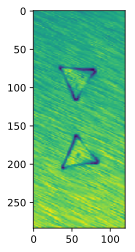

In [7]:
imshow(im);

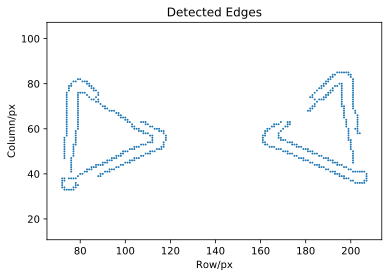

In [13]:
plot(x, y, 'o', markersize=1)
xlabel('Row/px')
ylabel('Column/px')
axis('equal');
title('Detected Edges');

## Use Major Axis to split particles
Theoretically, if a particle has symmetry for rotate $2\pi/3$, the moment of inertia $I_0$ is independent on the direction of axis as long as it passes the centroid. More general, for arbitrary axis, we can use parallel axis theorem to find $I=I_0+md^2$.

**Lemma** For two particles the major axis $\hat n$ of least moment of inertia must go through both centroid. 

So the major axis is used to estimate the line connecting both centroid. The information of another major axis $\hat m$ with greatest moment of inertia can also be used to **estimate the separation** $r$ between the centroids.

As $I_n\approx 2I_0, I_m\approx 2\left[I_0+m\left(\dfrac{r}{2}\right)^2\right]$, we have
$$\frac{r}{2}\approx\sqrt{\frac{I_M-I_m}{2m}}$$

If the two particles are separated far enough, we can separate them into two particles based on the major axis $\hat n$ and centroids $O$ of two particles by criteria $$\mathrm{sgn}\left[(\vec r_i-\vec r_O)\cdot \hat n\right]$$

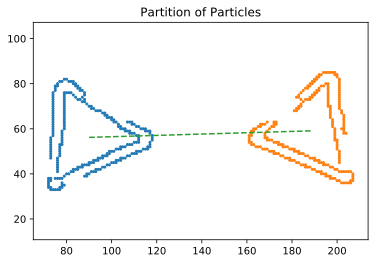

In [37]:
display.show_split(points)
display.show_axis(points)
axis('equal');
title('Partition of Particles');

When two particles are too close, the partition and the estimation of centroids may be inaccurate. But it will nevertheless give a good starting point. We will discuss this later.

## Use Triangles to Fit Particles 
Triangles are used to Fit Particles. Fitting parameters of Triangle $T$ are centroid position $C(x, y)$ and angle location $(\rho, \theta)$ with respect to centroid $C$. The idea is like https://link.springer.com/article/10.1007%2FBF00939613 : 

$$\mathrm{minimize}\left[\sum_i|\vec r_i-\vec r_C|^2d^2(\vec r_i, T)\right]$$

The initial estimation of centroid and angle should be given to ensure a good global minimum.

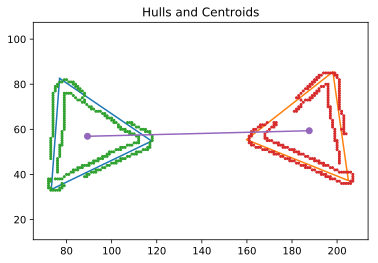

In [25]:
display.show_frame(points)
axis('equal');
title('Hulls and Centroids');

## Deal with close case

/home/zpj/code/capillary/doc/capillary/fitting.py:46: UserWarning: Particles are too close, separation may fail!
  warnings.warn("Particles are too close, separation may fail!")


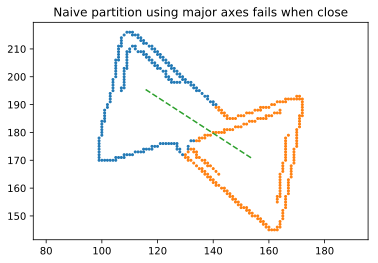

In [39]:
pts=edge.G[2](1196)
pos, neg = fitting.split(pts)
display.show_split(pos, neg)
display.show_axis(pts)
axis('equal');
title('Naive partition using major axes fails when close');

If we fit triangles on the wrong split, the result is still good.

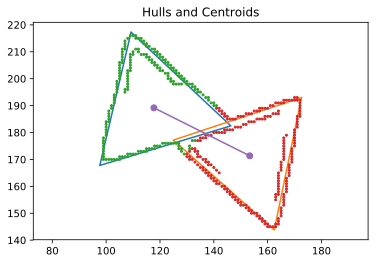

In [30]:
display.show_frame(pts)
axis('equal');
title('Hulls and Centroids');

This is a good starting point for our iteration:
1. Find a new split $S'$ based on the fitting triangles $T$.
1. Find new fitting triangle $T'$ based on $S'$

The $T\to S$ is given in last section. For the $S\to T$ step, the criteria for each point are:

$$d(\vec r_i, T)=\mathrm{distance}(\vec r_i, \mathrm{triangle}),$$

which is defined to be positive if point is inside a triangle and negative if outside. A point $P$ belongs to $T_1$ iff 

$$d(P, T_1) < d(P, T_2)+\Delta$$
The $\Delta$ is controlling the contiguous points which belongs to both. we are setting it to be 1 pixel.

Even one iteration could give fair result:

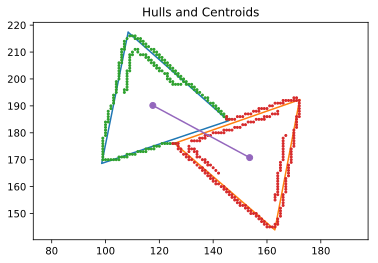

In [32]:
display.show_frame(pts, iterate=1)
axis('equal');
title('Hulls and Centroids');

Three iterations makes it perfect:

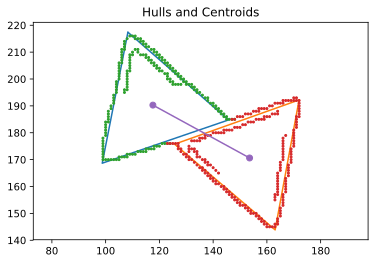

In [36]:
display.show_frame(pts, iterate=3)
axis('equal');
title('Hulls and Centroids');

## Deal with Touching thick border


Fix the dimension of triangle to fit?